Bibliotecas usadas.


*   numpy: Proporciona soporte para arrays y matrices de gran tamaño, junto con una colección de funciones matemáticas para operar con estos arrays de manera eficiente. Especialmente importante para la creación y manipulación de matrices complejas y arrays, cálculo de productos tensoriales (kronecker product) y
cálculo de valores propios y vectores propios (diagonalización de matrices).
*   matplotlib.pyplot: Generación de gráficos de los valores de expectación a lo largo del tiempo para visualizar la evolución del sistema cuántico.
*   time: Medición del tiempo de ejecución de diferentes partes del código (evolución usando RK4, diagonalización y evolución diagonalizada).






In [87]:
import numpy as np
import matplotlib.pyplot as plt
import time

Funciones implementadas.

operacion(orden): Esta función calcula el producto tensorial de una lista de matrices. El producto tensorial es esencial para construir operadores que actúan en el espacio de Hilbert de sistemas cuánticos compuestos, como un sistema de múltiples espines.

In [88]:
def operacion(orden):
    """
    Calcula el producto tensorial de una lista de matrices.

    Args:
        orden (list): Lista de matrices.

    Returns:
        np.ndarray: Producto tensorial de las matrices en la lista.
    """
    producto = orden[0]  # Inicia con la primera matriz en la lista
    for i in orden[1:]:
        producto = np.kron(producto, i)  # Aplica el producto tensorial sucesivamente
    return producto  # Retorna el resultado del producto tensorial

hamiltonian(J, g, N): Construye el Hamiltoniano del sistema de espines acoplados en presencia de un campo magnético. El Hamiltoniano define la dinámica del sistema cuántico y es fundamental para resolver la ecuación de Schrödinger. Incluye términos de acoplamiento entre espines y de interacción con un campo magnético.

In [89]:
def hamiltonian(J, g, N):
    """
    Construye el Hamiltoniano del sistema de espines.

    Args:
        J (float): Constante de acoplamiento entre espines.
        g (float): Intensidad del campo magnético.
        N (int): Número de espines.

    Returns:
        np.ndarray: Matriz del Hamiltoniano del sistema.
    """
    spins = np.zeros((2**N, 2**N), dtype=complex)  # Inicializa la matriz de acoplamiento de espines
    field = np.zeros((2**N, 2**N), dtype=complex)  # Inicializa la matriz de campo magnético

    # Construcción del término de acoplamiento de espines
    for i in range(N):
        j = (i + 1) % N  # Índice del vecino con condiciones periódicas
        orden = [iden] * N  # Lista de matrices identidad
        orden[i] = sz  # Reemplaza con sigma-z en la posición i
        orden[j] = sz  # Reemplaza con sigma-z en la posición j
        elemento = operacion(orden)  # Calcula el producto tensorial
        spins += elemento  # Suma el término al Hamiltoniano de espines

    # Construcción del término de campo magnético
    for i in range(N):
        orden = [iden] * N  # Lista de matrices identidad
        orden[i] = sx  # Reemplaza con sigma-x en la posición i
        elemento = operacion(orden)  # Calcula el producto tensorial
        field += elemento  # Suma el término al Hamiltoniano de campo

    H = -J * spins - g * field  # Suma los términos de acoplamiento y campo para formar el Hamiltoniano total
    return H  # Retorna la matriz del Hamiltoniano


evolucion_cuántica(psi_0_transformed, t, eigenvalues, eigenvectors): Evoluciona el estado cuántico inicial en el tiempo usando la diagonalización del Hamiltoniano. Permite calcular la evolución temporal del estado cuántico en la base de autoestados del Hamiltoniano, facilitando la solución de la ecuación de Schrödinger.

In [90]:
def evolucion_cuántica(psi_0_transformed, t, eigenvalues, eigenvectors):
    """
    Evoluciona el estado cuántico usando diagonalización.

    Args:
        psi_0_transformed (np.ndarray): Estado inicial transformado.
        t (float): Tiempo de evolución.
        eigenvalues (np.ndarray): Valores propios del Hamiltoniano.
        eigenvectors (np.ndarray): Vectores propios del Hamiltoniano.

    Returns:
        np.ndarray: Estado cuántico evolucionado.
    """
    # Calcula la evolución temporal en la base de autoestados del Hamiltoniano
    return np.dot(eigenvectors, np.exp(-1j * eigenvalues * t) * psi_0_transformed)


schrodinger_derivative(H, psi): Calcula la derivada temporal del estado cuántico según la ecuación de Schrödinger. Esta derivada es necesaria para implementar métodos numéricos como Runge-Kutta, que se utilizan para integrar la ecuación de Schrödinger en el tiempo.

In [91]:
def schrodinger_derivative(H, psi):
    """
    Calcula la derivada temporal del estado cuántico según la ecuación de Schrödinger.

    Args:
        H (np.ndarray): Hamiltoniano del sistema.
        psi (np.ndarray): Estado cuántico.

    Returns:
        np.ndarray: Derivada temporal del estado cuántico.
    """
    return -1j * np.dot(H, psi)  # Aplica la ecuación de Schrödinger


rk4_step(H, psi, dt): Realiza un paso de integración usando el método de Runge-Kutta de cuarto orden (RK4). El método RK4 es una técnica numérica para resolver ecuaciones diferenciales ordinarias, utilizada aquí para integrar la ecuación de Schrödinger y obtener la evolución temporal del estado cuántico.

In [92]:
def rk4_step(H, psi, dt):
    """
    Realiza un paso de integración usando el método de Runge-Kutta de cuarto orden (RK4).

    Args:
        H (np.ndarray): Hamiltoniano del sistema.
        psi (np.ndarray): Estado cuántico.
        dt (float): Paso de tiempo.

    Returns:
        np.ndarray: Estado cuántico actualizado.
    """
    # Calcula los incrementos k1, k2, k3 y k4 del método RK4
    k1 = dt * schrodinger_derivative(H, psi)
    k2 = dt * schrodinger_derivative(H, psi + 0.5 * k1)
    k3 = dt * schrodinger_derivative(H, psi + 0.5 * k2)
    k4 = dt * schrodinger_derivative(H, psi + k3)
    # Actualiza el estado psi usando la combinación ponderada de k1, k2, k3 y k4
    return psi + (k1 + 2*k2 + 2*k3 + k4) / 6

rk4_evolution(H, psi_0, times, dt, observable): Evoluciona el estado cuántico usando el método RK4 y calcula el valor de expectación de un observable a lo largo del tiempo. Esta función permite simular la evolución temporal del sistema y obtener información sobre cómo varían los valores de expectación de ciertos observables cuánticos en el tiempo.

In [93]:
def rk4_evolution(H, psi_0, times, dt, observable):
    """
    Evoluciona el estado cuántico usando el método de Runge-Kutta de cuarto orden (RK4) y calcula el valor de expectación.

    Args:
        H (np.ndarray): Hamiltoniano del sistema.
        psi_0 (np.ndarray): Estado cuántico inicial.
        times (np.ndarray): Tiempos de evolución.
        dt (float): Paso de tiempo.
        observable (np.ndarray): Observable cuyo valor de expectación se va a calcular.

    Returns:
        np.ndarray: Valores de expectación a lo largo del tiempo.
    """
    expectation_values = np.zeros(len(times))  # Inicializa el array de valores de expectación
    psi = psi_0.copy()  # Copia el estado inicial

    # Itera sobre cada instante de tiempo
    for idx, t in enumerate(times):
        # Calcula el valor de expectación del observable en el estado psi
        expectation_values[idx] = np.vdot(psi, np.dot(observable, psi)).real
        if idx < len(times) - 1:
            # Actualiza el estado psi usando un paso RK4
            psi = rk4_step(H, psi, dt)
    return expectation_values  # Retorna los valores de expectación


expectation_value(state, observable): Calcula el valor de expectación de un observable en un estado cuántico dado. El valor de expectación proporciona información sobre el resultado promedio de una medición del observable en el estado cuántico, lo cual es crucial para interpretar la evolución del sistema.

In [94]:
def expectation_value(state, observable):
    """
    Calcula el valor de expectación de un observable en un estado dado.

    Args:
        state (np.ndarray): Estado cuántico.
        observable (np.ndarray): Observable.

    Returns:
        float: Valor de expectación.
    """
    # Calcula y retorna el valor de expectación del observable en el estado dado
    return np.vdot(state, np.dot(observable, state)).real

operador_z_n_espin(i, N): Construye el operador sigma-z para el i-ésimo espín en un sistema de N espines. Los operadores de Pauli sigma-z son utilizados para definir los términos del Hamiltoniano y calcular los valores de expectación de los espines individuales, proporcionando una medida de la magnetización del sistema

In [95]:
def operador_z_n_espin(i, N):
    """
    Construye el operador Z para el i-ésimo espín en un sistema de N espines.

    Args:
        i (int): Índice del espín.
        N (int): Número de espines.

    Returns:
        np.ndarray: Operador Z para el i-ésimo espín.
    """
    operadores = [iden] * N  # Lista de matrices identidad
    operadores[i] = sz  # Reemplaza con sigma-z en la posición i
    return operacion(operadores)  # Calcula y retorna el producto tensorial

Variables del sistema

In [96]:
# Definición de las matrices de Pauli y otras constantes
sx = np.array([[0, 1], [1, 0]], dtype=complex)  # Matriz de Pauli sigma-x
sz = np.array([[1, 0], [0, -1]], dtype=complex)  # Matriz de Pauli sigma-z
iden = np.eye(2, dtype=complex)  # Matriz identidad 2x2

N = 10  # Número de espines en el sistema
J = 1.0  # Constante de acoplamiento entre espines
g = 1.0  # Intensidad del campo magnético
psi_0 = np.zeros(2**N, dtype=complex)  # Estado inicial del sistema (vector nulo)
psi_0[1] = 1  # Define el segundo elemento del estado inicial
espines = list(range(N))  # Lista de índices de los espines

H = hamiltonian(J, g, N)  # Construye el Hamiltoniano del sistema
times = np.linspace(0, 10, 1000)  # Array de tiempos de evolución
dt = times[1] - times[0]  # Paso de tiempo entre instantes

# Almacenar los valores de expectación
expectation_values_diag = {}  # Diccionario para almacenar valores de expectación (diagonalización)
expectation_values_rk4 = {}  # Diccionario para almacenar valores de expectación (RK4)

Implementación de RK4:

In [97]:
# Evolución con RK4
start_time_rk4 = time.time()  # Inicia la medición del tiempo de evolución con RK4
for i in espines:
    observable = operador_z_n_espin(i, N)  # Construye el operador Z para el i-ésimo espín
    expectation_values_rk4[i] = rk4_evolution(H, psi_0, times, dt, observable)  # Calcula la evolución y los valores de expectación
rk4_total_time = time.time() - start_time_rk4  # Calcula el tiempo total de evolución con RK4
print(f"Tiempo de evolución con RK4: {rk4_total_time:.4f} s")  # Imprime el tiempo total de evolución con RK4

Tiempo de evolución con RK4: 66.7101 s


Graficación RK4:

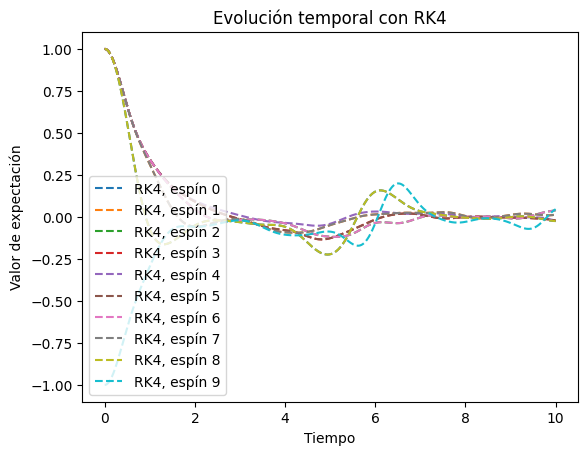

In [98]:
# Plot de la evolución temporal con RK4
plt.figure()
for i in espines:
    plt.plot(times, expectation_values_rk4[i], '--', label=f'RK4, espín {i}')  # Grafica los valores de expectación
plt.xlabel('Tiempo')
plt.ylabel('Valor de expectación')
plt.title('Evolución temporal con RK4')
plt.legend()
plt.show()

Implementación de la diagonalización:


In [99]:
# Diagonalización del Hamiltoniano y cálculo de psi_0'
start_time_diag = time.time()  # Inicia la medición del tiempo de diagonalización
eigenvalues, eigenvectors = np.linalg.eigh(H)  # Calcula los valores y vectores propios del Hamiltoniano
psi_0_transformed = np.dot(eigenvectors.conj().T, psi_0)  # Transforma el estado inicial a la base de vectores propios
diag_time = time.time() - start_time_diag  # Calcula el tiempo total de diagonalización
print(f"Tiempo de diagonalización y rotación del vector inicial: {diag_time:.4f} s")  # Imprime el tiempo total de diagonalización

# Evolución diagonalizada
start_time_evolution_diag = time.time()  # Inicia la medición del tiempo de evolución diagonalizada
for i in espines:
    observable = operador_z_n_espin(i, N)  # Construye el operador Z para el i-ésimo espín
    expectation_values_diag[i] = np.zeros(len(times))  # Inicializa el array de valores de expectación
    for idx, t in enumerate(times):
        psi_t = evolucion_cuántica(psi_0_transformed, t, eigenvalues, eigenvectors)  # Evoluciona el estado cuántico
        expectation_values_diag[i][idx] = expectation_value(psi_t, observable)  # Calcula el valor de expectación
evolution_diag_time = time.time() - start_time_evolution_diag  # Calcula el tiempo total de evolución diagonalizada
print(f"Tiempo de evolución diagonalizada: {evolution_diag_time:.4f} s")  # Imprime el tiempo total de evolución diagonalizada
# Imprimir tiempo total del método
print(f"Tiempo total de diagonalización y evolución: {diag_time + evolution_diag_time:.4f} s")  # Imprime el tiempo total de diagonalización y evolución

Tiempo de diagonalización y rotación del vector inicial: 3.8717 s
Tiempo de evolución diagonalizada: 34.5828 s
Tiempo total de diagonalización y evolución: 38.4545 s


Graficación Diagonalización:

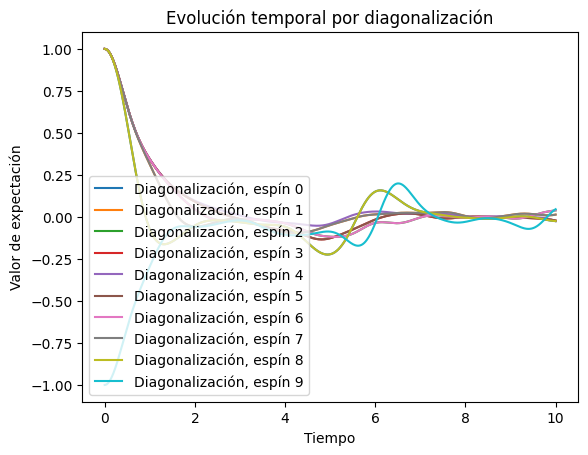

In [100]:
# Plot de la evolución temporal por diagonalización
plt.figure()
for i in espines:
    plt.plot(times, expectation_values_diag[i], label=f'Diagonalización, espín {i}')  # Grafica los valores de expectación
plt.xlabel('Tiempo')
plt.ylabel('Valor de expectación')
plt.title('Evolución temporal por diagonalización')
plt.legend()
plt.show()

Comparación de la evolución temporal de RK4 y diagonalización

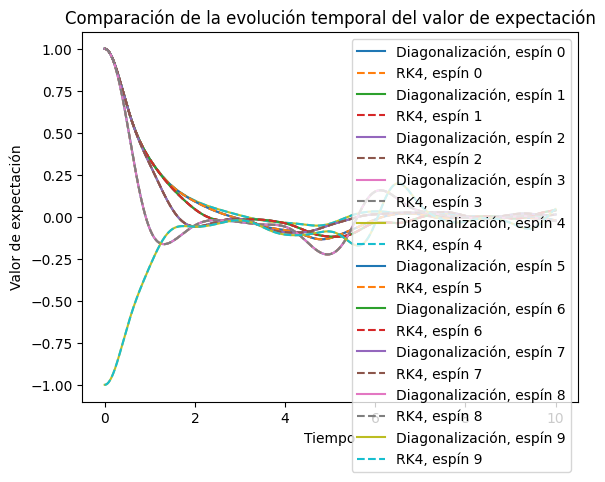

In [101]:
# Comparación de la evolución temporal
plt.figure()
for i in espines:
    plt.plot(times, expectation_values_diag[i], label=f'Diagonalización, espín {i}')  # Grafica los valores de expectación (diagonalización)
    plt.plot(times, expectation_values_rk4[i], '--', label=f'RK4, espín {i}')  # Grafica los valores de expectación (RK4)
plt.xlabel('Tiempo')
plt.ylabel('Valor de expectación')
plt.title('Comparación de la evolución temporal del valor de expectación')
plt.legend()
plt.show()